Nama : Yosriko Rahmat Karoni Sabelekake

EMAIL: yosrikosabelekake@gmail.com

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from PIL import Image
import numpy as np
import io
from IPython.display import Image as IPImage, display
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import Callback

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/colabNotebooks/rockpaperscissors.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
!sudo apt install tree
!tree -d /tmp

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (874 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121918 files and directories currently install

In [ ]:
#split dataset dengan rasio 0.6(train) - 0.4(validation)
!pip install split-folders
import splitfolders
splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images/',
                    output ='/tmp/rockpaperscissors/rps-cv-images/data_model',
                    seed=None, ratio=(.6,.4))

Copying files: 2188 files [00:00, 2968.41 files/s]


In [ ]:
#Menghitung jumlah data
import os

train_dir = '/tmp/rockpaperscissors/rps-cv-images/data_model/train'
val_dir = '/tmp/rockpaperscissors/rps-cv-images/data_model/val'

def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_files(train_dir)
val_count = count_files(val_dir)

print("Number of images in training set:", train_count)
print("Number of images in validation set:", val_count)


Number of images in training set: 1312
Number of images in validation set: 876


In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to remove background from an image
def remove_background(image):
    # Perform background removal here (using your preferred method/library)
    # For example, using OpenCV's grabCut algorithm
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a mask
    mask = np.zeros_like(gray)
    # Define background and foreground models
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    # Define rectangle for background estimation
    rect = (50,50,450,290) # Example rectangle, you may need to adjust
    # Apply grabCut algorithm
    cv2.grabCut(image,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    # Create mask where background is 2 or 0, foreground is 1 or 3
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    # Multiply image with mask to get the final result
    image = image*mask2[:,:,np.newaxis]
    return image

# Define a custom data generator with background removal
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def preprocess_image(self, x):
        # Add background removal step here
        x = remove_background(x)
        return x

# Initialize a custom data generator for training
train_datagen = CustomImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

# Other parts of your code remain unchanged
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=40,
    class_mode='categorical')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=40,
    class_mode='categorical')



Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

class StopCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.98:
            print("\nAccuracy has reached 0.98, stopping training.")
            self.model.stop_training = True

callbacks = StopCallback()
model.summary()
train_models = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[callbacks],
)

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21170755 (80.76 MB)
Trainable params: 6456067 (24.63 MB)
Non-trainable params: 14714688 (56.13 MB)
__________

Saving hand-in-gesture-for-the-game-of-rock-paper-scissorsrock-gesture-2CCH5RE.jpg to hand-in-gesture-for-the-game-of-rock-paper-scissorsrock-gesture-2CCH5RE.jpg


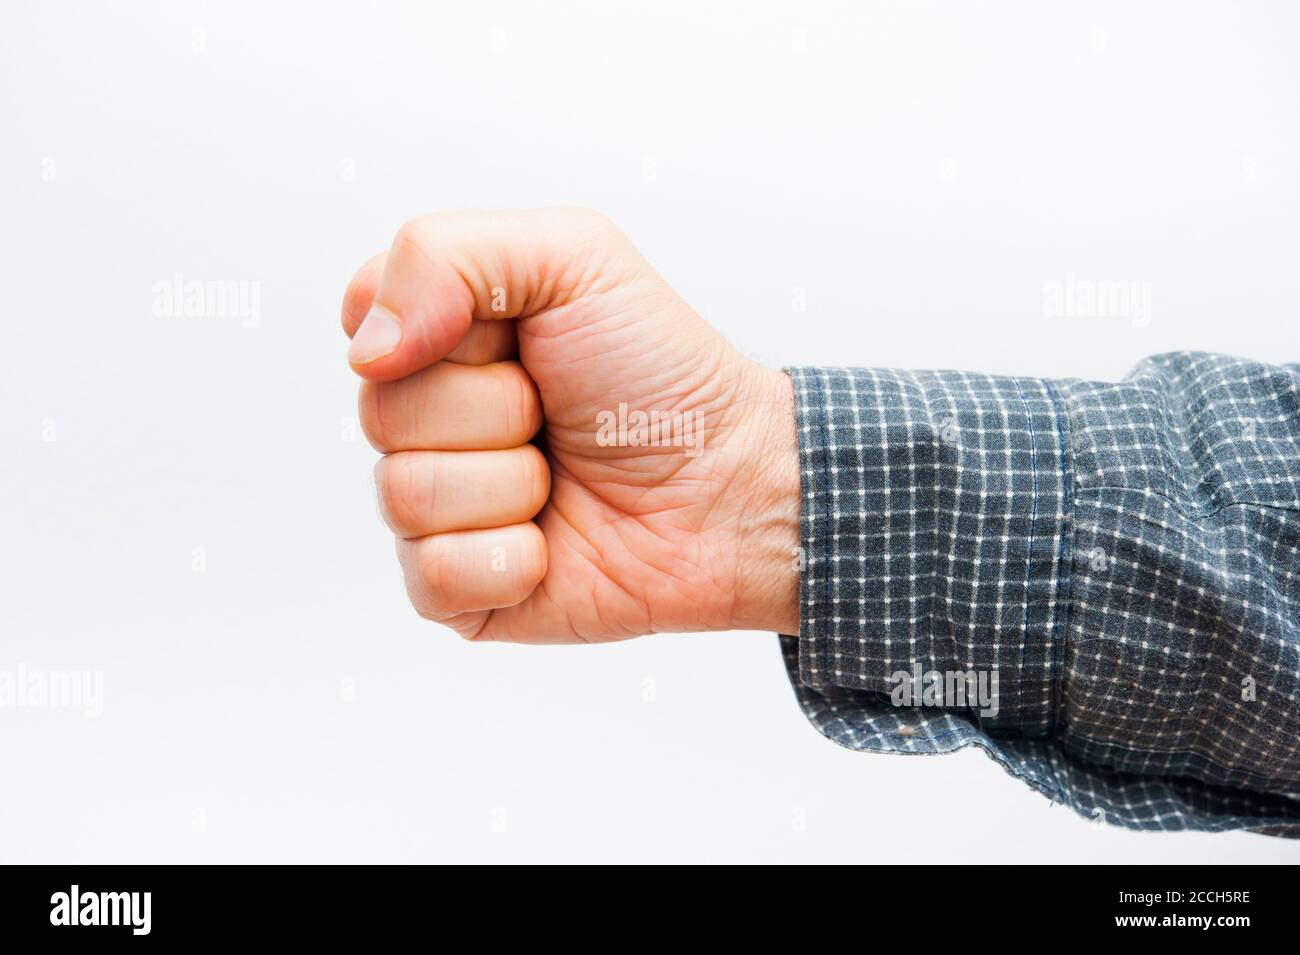

1/1 [==============================] - 1s 1s/step
Predicted Label: rock


In [ ]:
uploaded_files = files.upload()
image_path = list(uploaded_files.keys())[0]

display(IPImage(filename=image_path))

image = Image.open(io.BytesIO(uploaded_files[image_path]))
image = image.resize((224, 224))
image_array = np.array(image) / 255.0

image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)

labels = train_generator.class_indices

predicted_label_index = np.argmax(predictions)
predicted_label = list(labels.keys())[predicted_label_index]

print("Predicted Label:", predicted_label)
